In [1]:
%matplotlib inline

# Machine learning related
from sklearn.base import BaseEstimator # Base class to create a custom estimator / classifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier
from sklearn.model_selection import cross_val_score, cross_val_predict # Cross validation

# Auxiliary tools
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
DATASET_PATH = Path("..", "Datasets").resolve()

## Downloading the dataset using sklearn

In [3]:
mnist = fetch_openml('mnist_784', version=1, data_home=DATASET_PATH) # Downloading
# mnist is a dictionary with the images, labels and many others characteristics, we can check them by printing the keys of that dictionary
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- DESCR: Describes the dataset;
- data: Array containing one row per instance and one columnn per feature;
- target: Array containing the labels



# UNDERSTANDING THE DATA
---

X shape: (70000, 784) / y shape: (70000,)


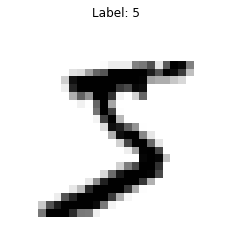

In [4]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8) # Casting all items in y from string to int
print("X shape: {} / y shape: {}".format(X.shape, y.shape))

# Any digit is an array with all the pixels data, so we need to reshape it to an image (matrix) in this case with shape 28x28
some_digit = X[0].reshape(28,28)

plt.imshow(some_digit, cmap="binary")
plt.title("Label: {}".format(y[0]))
plt.axis("off")
plt.show()

# TRAIN/TEST SPLIT

---

### mnist is already split, 0~60.000 is a shuffled training set and 60.000~70.000 is the test set

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# TRAINING THE MODEL

---

### The first model will only classify images as '5' or 'not 5'.

In [6]:
y_train_5 = (y_train == 5) # Generate a mask to distinct fives (true) from not fives (false)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42) # Instantiate using a seed, to make the result reproducible
sgd_clf.fit(X_train, y_train_5) # Train

SGDClassifier(random_state=42)

In [7]:
# Using the model to predict if the previous shown image is a five
sgd_clf.predict([X[0]])

array([ True])

# EVALUATING THE MODEL

---

### Measuring accuracy using cross-validation

In [8]:
cross_val_score(
    sgd_clf, # Model instance
    X_train, # Training data
    y_train_5, # Training labels
    cv=3, # Number of folds
    scoring='accuracy' # Evaluation metric
)

array([0.95035, 0.96035, 0.9604 ])

### Model has over 95% accuracy consistently, but that doesn't mean much since only about 10% of the images on the training set were fives and 90% were not fives... So a classifier that just guesses not 5 every time would be correct 90% of the time (as shown bellow)

In [9]:
# Creating the model that only guesses 'not 5'
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, Xs):
        return np.zeros((len(Xs), 1), dtype=bool)

# Evaluating
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### 90% accuracy, as expected...

### That is why accuracy may be a bad measurement for classifiers, especially using skewed datasets

## Let's try a ___confusion matrix___

In [10]:
# Retraining and getting the result for each prediction on the test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [11]:
# Creating the confusion matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

| [v] Dataset \\ Predicted [>] | not 5 | is 5 |
| ---- | ----- | ---- |
| not 5 | True Negatives | False Positives |
| is 5 | False Negatives | True Positives |
                                <---------- Recall ^
                                                   |
                                                   |
                                                   precision

- ## __Precision of 'A':__ Of all 'A' predictions, how many were correct
- ## __Recall of 'A':__ Of all 'A' on the dataset, how many were predicted

## Other metrics:

In [12]:
# === PRECISION === #
# p = TP / (TP + FP)
def cm2precision(cm):
    # cm = confusion matrix
    return cm[1][1] / (cm[1][1] + cm[0][1])
print("precision (skl) = {}\nprecision (manual) = {}".format(
    precision_score(y_train_5, y_train_pred),
    cm2precision(cm)
))
# === RECALL / TPR / SENSITIVITY === #
# TPR : True Positive Rate
# r = TP / (TP + FN)

precision (skl) = 0.8370879772350012
precision (manual) = 0.8370879772350012
